In [1]:
import argparse
import random

import numpy as np
import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from ignite.engine import Engine, Events
from ignite.handlers import ModelCheckpoint
from torch.utils.data import DataLoader, IterableDataset, get_worker_info

CHECKPOINT_PREFIX = "g2g"

from g2g_model_Fisher import CompleteKPartiteGraph,AttributedGraph,GraphDataset,Encoder,\
                            level_sets,train_test_split,reset_seeds

C:\Users\76745\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import scvelo as scv
import numpy as np
from anndata import AnnData
# import loompy
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import fcluster,leaders
from sklearn.decomposition import PCA
from scipy.linalg import inv
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from RKHS import SparseVFC
from RKHS import Jacobian_rkhs_gaussian
from scipy.stats import multivariate_normal
from scipy.sparse import csr_matrix

In [3]:
##读取数据
data_path='data/'
result_path='result/'
adata0=scv.read(data_path+'DG_bin.h5ad', cache=True)

In [4]:
adata0

AnnData object with n_obs × n_vars = 3184 × 678
    obs: 'Age', 'Cell_Conc', 'ChipID', 'ClusterName', 'Clusters', 'Comments', 'Date_Captured', 'DonorID', 'Label', 'NGI_PlateWell', 'Num_Pooled_Animals', 'PCR_Cycles', 'Plug_Date', 'Project', 'SampleID', 'SampleOK', 'Sample_Index', 'Seq_Comment', 'Seq_Lib_Date', 'Seq_Lib_Ok', 'Serial_Number', 'Sex', 'Species', 'Strain', 'TSNE1', 'TSNE2', 'Target_Num_Cells', 'Tissue', 'Transcriptome', 'cDNA_Lib_Ok', 'ngperul_cDNA', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'ClusterName_colors', 'neighbors', 'pca', 'umap', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_pca'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'unsplic

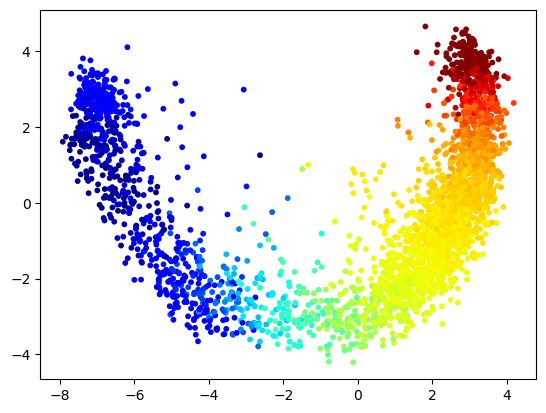

In [5]:
plt.scatter(adata0.obsm['X_pca'][:,0],adata0.obsm['X_pca'][:,1],s=10,c=adata0.obs['velocity_pseudotime'].values,cmap=plt.cm.jet)
plt.show()

# plt.scatter(adata0.obsm['X_pca'][:,0],adata0.obsm['X_pca'][:,1],s=10,c=adata0.layers['variance_velocity'],cmap=plt.cm.jet)
# plt.show()

In [15]:
#-------data preprocessing
k_nei=10
adata=adata0.copy()
scv.pp.neighbors(adata, n_neighbors=k_nei)           ##
scv.pp.pca(adata,n_comps=50)                         ##
scv.pp.moments(adata, n_pcs=50, n_neighbors=k_nei)   ##

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [16]:
row = np.array([np.ones((k_nei,))*i for i in range(adata.shape[0])]).flatten()

col=adata.uns['neighbors']['indices'].flatten()

adj_val=np.ones(col.shape)

A_mat=csr_matrix((adj_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))

X0_ori=adata0.layers['Ms']#adata.X.A#
scaler=MinMaxScaler(feature_range=(0,1))#StandardScaler()#
X=scaler.fit_transform(X0_ori)

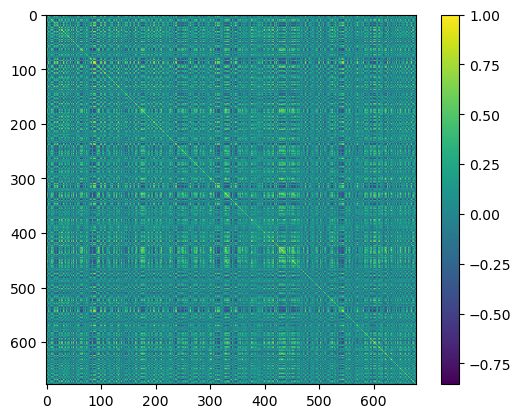

In [17]:
X_corr=np.corrcoef(X, rowvar=False)
plt.imshow(X_corr)
plt.colorbar()
plt.show()

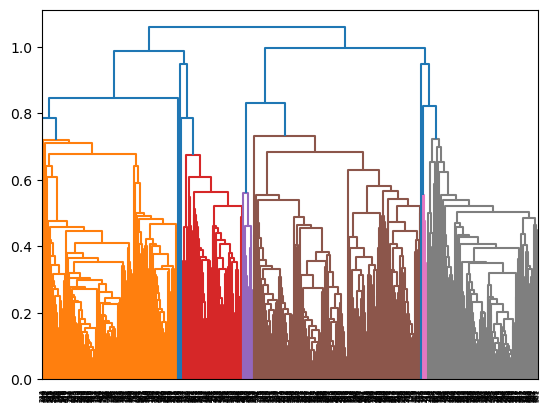

In [18]:
Z=linkage((1-X_corr)[np.triu_indices(X_corr.shape[0],k=1)],method='weighted')
dg=dendrogram(Z)
X_re= X[:,dg['leaves']]#X_re reorder X by clustering

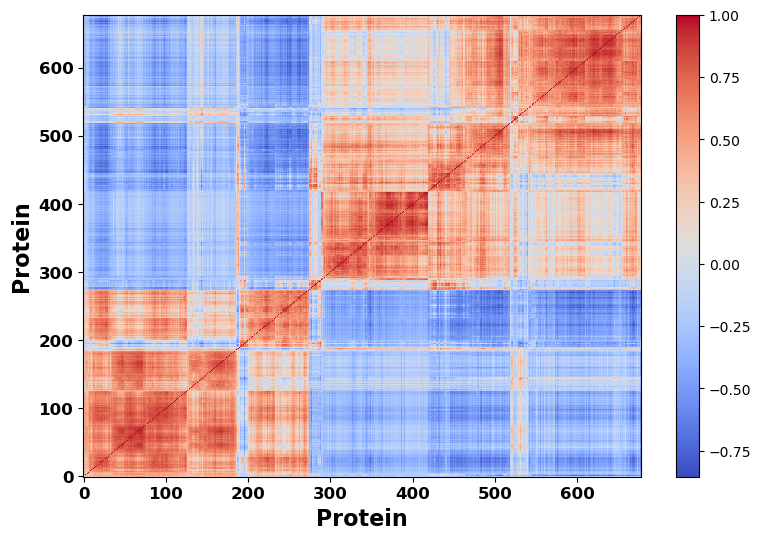

In [19]:
X_corr_re=np.corrcoef(X_re, rowvar=False)

plt.figure(figsize=(9,6))
plt.imshow(X_corr_re, aspect='auto', cmap=plt.cm.coolwarm, interpolation='nearest',origin='lower')

plt.xlabel('Protein',fontsize=16,fontweight='bold')
plt.ylabel('Protein',fontsize=16,fontweight='bold')

plt.xticks(fontsize=12,fontweight='bold')
plt.yticks(fontsize=12,fontweight='bold')
plt.colorbar()
# plt.savefig('heatmap_order.png',dpi=300)
plt.show()

In [21]:
epochs = 1000
nsamples = 5
learning_rate = 1e-3
seed = 0
n_workers = 0          ### num_workers数目设置
K = 4# !!!!!!!!!! K should be large enough
#     checkpoint_path = args.checkpoint
#     checkpoints_path = args.checkpoints
#     dataset_path = args.dataset6

if seed is not None:
    reset_seeds(seed)

A=A_mat
X=X0_ori
#--------do not normalize X
# scaler=StandardScaler()#
# X=scaler.fit_transform(X0_ori)
z=adata0.obs['velocity_pseudotime'].values

n = A.shape[0]

train_nodes, val_nodes = train_test_split(n, train_ratio=1.0)
#train_nodes, val_nodes = train_test_split(n, train_ratio=0.75)

A_train = A[train_nodes, :][:, train_nodes]
X_train = X[train_nodes]
z_train = z[train_nodes]
A_val = A[val_nodes, :][:, val_nodes]
X_val = X[val_nodes]
z_val = z[val_nodes]

train_data = AttributedGraph(A_train, X_train, z_train, K)
val_data = AttributedGraph(A_val, X_val, z_val, K)

L = 256       ## 稍微大一些，用于寻找 latent dimension
encoder = Encoder(X.shape[1], L)

In [22]:
optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)

iterations = epochs ## // n_workers  #不可为0
dataset = GraphDataset(train_data, nsamples, iterations)
loader = DataLoader(
    dataset,
    batch_size=1,
    num_workers=n_workers,
    worker_init_fn=reset_seeds,
    collate_fn=lambda args: args,
)

0 tensor(3.5250e+11, grad_fn=<DivBackward0>)
50 tensor(5.4646e+09, grad_fn=<DivBackward0>)
100 tensor(4.8936e+09, grad_fn=<DivBackward0>)
150 tensor(4.6323e+09, grad_fn=<DivBackward0>)
200 tensor(4.5138e+09, grad_fn=<DivBackward0>)
250 tensor(4.4905e+09, grad_fn=<DivBackward0>)
300 tensor(4.4080e+09, grad_fn=<DivBackward0>)
350 tensor(4.3949e+09, grad_fn=<DivBackward0>)
400 tensor(4.3829e+09, grad_fn=<DivBackward0>)
450 tensor(4.3702e+09, grad_fn=<DivBackward0>)
500 tensor(4.3786e+09, grad_fn=<DivBackward0>)
550 tensor(4.3937e+09, grad_fn=<DivBackward0>)
600 tensor(4.3584e+09, grad_fn=<DivBackward0>)
650 tensor(4.3606e+09, grad_fn=<DivBackward0>)
700 tensor(4.3159e+09, grad_fn=<DivBackward0>)
750 tensor(4.3503e+09, grad_fn=<DivBackward0>)
800 tensor(4.3492e+09, grad_fn=<DivBackward0>)
850 tensor(4.3307e+09, grad_fn=<DivBackward0>)
900 tensor(4.3308e+09, grad_fn=<DivBackward0>)
950 tensor(4.3052e+09, grad_fn=<DivBackward0>)


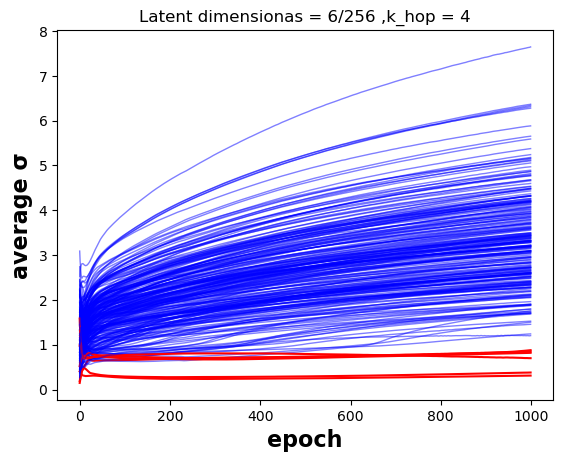

6
[43, 200, 204, 207, 236, 237]


In [23]:
sigma_step = []
latent_dim = []
non_inc = 0

for batch_idx, data in enumerate(loader):
    encoder.train()
    optimizer.zero_grad()

    loss = encoder.compute_loss(data[0][0],data[0][1],data[0][2],data[0][3],data[0][4],data[0][5])
    
    #mu, sigma = encoder.forward(data[0][0])
    mu, sigma = encoder(train_data.X)
    sigma_aver = torch.sum(sigma,dim = 0)/n

    sigma_step.append(sigma_aver.detach().numpy())
    if batch_idx% 50 == 0:        
        print(batch_idx,loss)
    loss.backward()
    optimizer.step()
    
sigma_step = np.array(sigma_step)

plt.figure()

plt.xlabel('epoch',fontsize=16,fontweight='bold')
plt.ylabel('average σ',fontsize=16,fontweight='bold')


for i in range(L):
    
    if sigma_step[-1,i] < 1:
        non_inc += 1
        latent_dim.append(i)
        plt.plot(range(epochs),sigma_step[:,i], color='red')
    elif sigma_step[epochs//2,i] < sigma_step[0,i]:
        plt.plot(range(epochs),sigma_step[:,i], color='y')
    else:
        plt.plot(range(epochs),sigma_step[:,i], color='blue',alpha = 0.5,lw = 1)

plt.title('Latent dimensionas = {non_inc}/{L} ,k_hop = {K}'.format(non_inc = non_inc,K = K,L = L))
plt.savefig('result/k_nei = {k_nei}&k_hop = {K}&L = {L}.png'.format(k_nei = k_nei,K = K,L = L),dpi = 300)
plt.show()
print(non_inc)
print(latent_dim)

0 tensor(1.5726e+10, grad_fn=<DivBackward0>)
50 tensor(4.3484e+09, grad_fn=<DivBackward0>)
100 tensor(4.3708e+09, grad_fn=<DivBackward0>)
150 tensor(4.3055e+09, grad_fn=<DivBackward0>)
200 tensor(4.2834e+09, grad_fn=<DivBackward0>)
250 tensor(4.3319e+09, grad_fn=<DivBackward0>)
[array(4.3031644e+09, dtype=float32)]
0 tensor(3.4821e+10, grad_fn=<DivBackward0>)
50 tensor(4.3840e+09, grad_fn=<DivBackward0>)
100 tensor(4.3519e+09, grad_fn=<DivBackward0>)
150 tensor(4.3317e+09, grad_fn=<DivBackward0>)
200 tensor(4.3466e+09, grad_fn=<DivBackward0>)
250 tensor(4.3626e+09, grad_fn=<DivBackward0>)
[array(4.3031644e+09, dtype=float32), array(4.319141e+09, dtype=float32)]
0 tensor(9.2062e+09, grad_fn=<DivBackward0>)
50 tensor(4.4027e+09, grad_fn=<DivBackward0>)
100 tensor(4.3306e+09, grad_fn=<DivBackward0>)
150 tensor(4.3496e+09, grad_fn=<DivBackward0>)
200 tensor(4.3447e+09, grad_fn=<DivBackward0>)
250 tensor(4.3235e+09, grad_fn=<DivBackward0>)
[array(4.3031644e+09, dtype=float32), array(4.31914

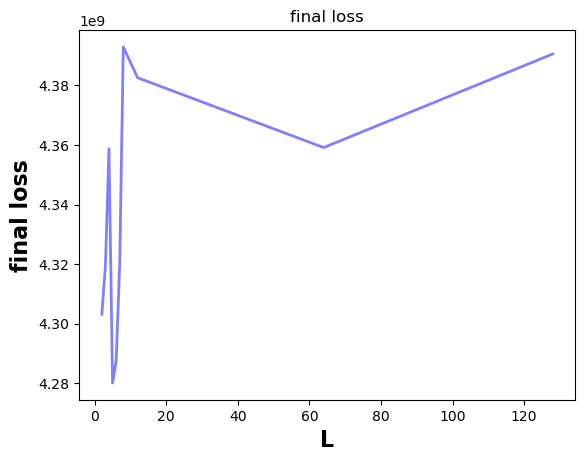

In [24]:
##循环K_hop

epochs = 300
nsamples = 5
learning_rate = 1e-3
seed = 0
n_workers = 0          ### num_workers数目设置
# !!!!!!!!!! K should be large enough
#     checkpoint_path = args.checkpoint
#     checkpoints_path = args.checkpoints
#     dataset_path = args.dataset6

if seed is not None:
    reset_seeds(seed)

A=A_mat
X=X0_ori
#--------do not normalize X
# scaler=StandardScaler()#
# X=scaler.fit_transform(X0_ori)
z=adata0.obs['velocity_pseudotime'].values

n = A.shape[0]

train_nodes, val_nodes = train_test_split(n, train_ratio=1.0)
#train_nodes, val_nodes = train_test_split(n, train_ratio=0.75)

L = 128     ## 稍微大一些，用于寻找 latent dimension
for K in [4,5]:

#K = 4
#final_loss = []
#L_lst = [2,3,4,5,6,7,8,12,64,128]
#for L in L_lst:

    A_train = A[train_nodes, :][:, train_nodes]
    X_train = X[train_nodes]
    z_train = z[train_nodes]
    A_val = A[val_nodes, :][:, val_nodes]
    X_val = X[val_nodes]
    z_val = z[val_nodes]
    
    train_data = AttributedGraph(A_train, X_train, z_train, K)
    val_data = AttributedGraph(A_val, X_val, z_val, K)
    

    encoder = Encoder(X.shape[1], L)
    
    optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    
    iterations = epochs ## // n_workers  #不可为0
    dataset = GraphDataset(train_data, nsamples, iterations)
    loader = DataLoader(
        dataset,
        batch_size=1,
        num_workers=n_workers,
        worker_init_fn=reset_seeds,
        collate_fn=lambda args: args,
    )
    
    sigma_step = []  ##
    non_inc = 0
    
    for batch_idx, data in enumerate(loader):
        encoder.train()
        optimizer.zero_grad()
    
        loss = encoder.compute_loss(data[0][0],data[0][1],data[0][2],data[0][3],data[0][4],data[0][5])
        
        mu, sigma = encoder.forward(data[0][0])
    
        mu, sigma = encoder(train_data.X)
        sigma_aver = torch.sum(sigma,dim = 0)/n        
        sigma_step.append(sigma_aver.detach().numpy())

        if batch_idx% 50 == 0:        
            print(batch_idx,loss)
        loss.backward()
        optimizer.step()
        
    sigma_step = np.array(sigma_step)
    
    final_loss.append(loss.detach().numpy())
    
    print(final_loss)

###plot loss    
#plt.figure()
#plt.xlabel('L',fontsize=16,fontweight='bold')
#plt.ylabel('final loss',fontsize=16,fontweight='bold')
#
#plt.plot(L_lst,final_loss, color='blue',alpha = 0.5,lw = 2)
#
#plt.title('final loss')
#plt.savefig('result/loss k_nei = {k_nei}&k_hop = {K}.png'.format(k_nei = k_nei,K = K),dpi = 300)
#plt.show()


    plt.figure()
    
    plt.xlabel('epoch',fontsize=16,fontweight='bold')
    plt.ylabel('average σ',fontsize=16,fontweight='bold')
    
    
    for i in range(L):
        
        if sigma_step[-1,i] < 1:
            non_inc += 1
            plt.plot(range(epochs),sigma_step[:,i], color='red')
        elif sigma_step[epochs//2,i] < sigma_step[0,i]:
            plt.plot(range(epochs),sigma_step[:,i], color='y')
        else:
            plt.plot(range(epochs),sigma_step[:,i], color='blue',alpha = 0.5,lw = 1)
    
    plt.title('Latent dimensionas = {non_inc}/{L} ,k_hop = {K}'.format(non_inc = non_inc,K = K,L = L))
    plt.savefig('result/k_nei = {k_nei}&k_hop = {K}&L = {L}.png'.format(k_nei = k_nei,K = K,L = L),dpi = 300)
    plt.show()
    print(non_inc)

In [24]:
z=train_data.z
mu, sigma = encoder(train_data.X)
mu_learned = mu.detach().numpy()
sigma_learned = np.sqrt(sigma.detach().numpy())

In [47]:
##排序对应
sort_idx = z.argsort()

match_idx=sort_idx[np.searchsorted(z,adata0.obs['velocity_pseudotime'].values,sorter = sort_idx)]
print(match_idx)
print(sort_idx)
print(np.searchsorted(z,adata0.obs['velocity_pseudotime'].values,sorter = sort_idx))
print(adata0.obs['velocity_pseudotime'].values,z[match_idx])


[2881 2374 1838 ...  695 1556 1497]
[1878 3167 2076 ... 1602 2863 2104]
[ 575 1189 1655 ...  308  352 1654]
[0.12311147 0.61953276 0.65022027 ... 0.10391717 0.10833498 0.65020245] [0.12311147 0.61953276 0.65022027 ... 0.10391717 0.10833498 0.65020245]
[1509 1266 2875  592 2431 2964]


In [57]:
X_mu=mu_learned[match_idx]
X_sigma=sigma_learned[match_idx]

X_sigma_latent = X_sigma[:,latent_dim]
X_sigma_lacking = X_sigma_latent[:,:non_inc//2]
X_sigma_lacking

array([[0.86155266, 0.61732733, 1.0334132 ],
       [0.9233716 , 0.60844594, 0.9251425 ],
       [0.93590873, 0.6158634 , 0.9104757 ],
       ...,
       [0.88145113, 0.61974806, 0.9965193 ],
       [0.8545391 , 0.6203686 , 1.0359112 ],
       [0.9280066 , 0.61714745, 0.915484  ]], dtype=float32)

In [58]:
# latent_z=[]
# for i in range(X_mu.shape[1]):
#     latent_z.append(X_mu[:,i])
#     latent_z.append(X_sigma[:,i])
# latent_z=np.array(latent_z).T
latent_z=np.hstack((X_mu,X_sigma))

latent_z.shape

(3184, 512)

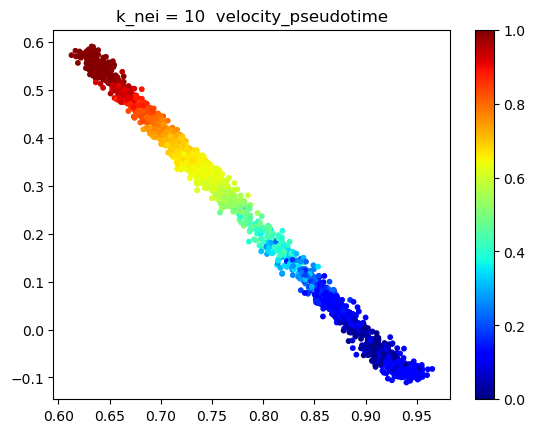

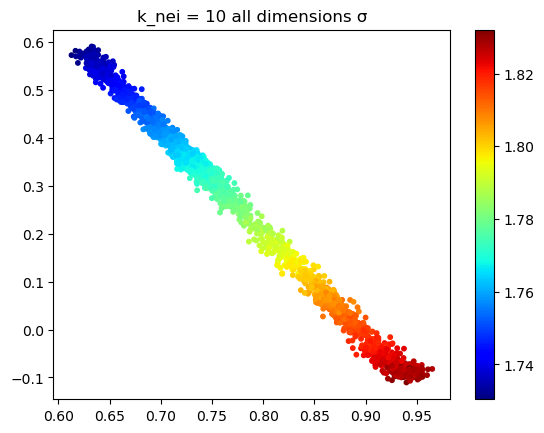

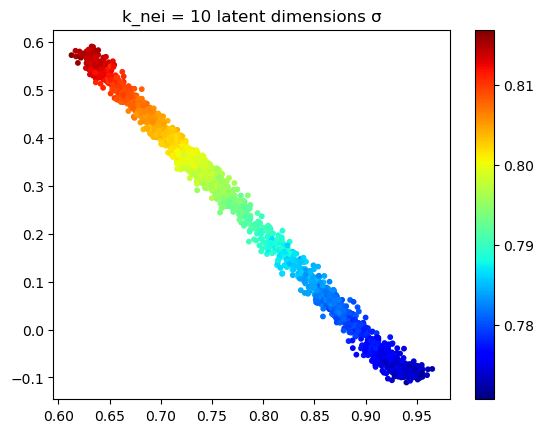

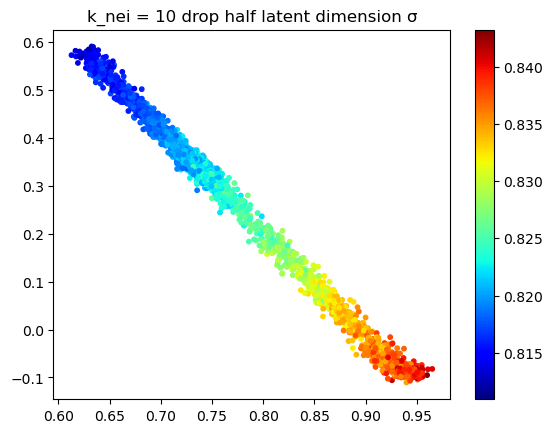

In [59]:
##velocity_pseudotime
plt.scatter(X_mu[:,0],X_mu[:,1],s=10,c=adata0.obs['velocity_pseudotime'].values,cmap=plt.cm.jet)
plt.title('k_nei = {k_nei}  velocity_pseudotime'.format(k_nei = k_nei))
plt.colorbar()
plt.savefig('result/k_nei = {k_nei} velocity_pseudotime.png'.format(k_nei = k_nei),dpi = 300)
plt.show()

##all dimensions
plt.scatter(X_mu[:,0],X_mu[:,1],s=10,c=np.sum(X_sigma/L,axis=1),cmap=plt.cm.jet)
plt.title('k_nei = {k_nei} all dimensions σ'.format(k_nei = k_nei))
plt.colorbar()
plt.savefig('result/k_nei = {k_nei}all dimensions σ'.format(k_nei = k_nei),dpi = 300)
plt.show()


##latent dimensions
plt.scatter(X_mu[:,0],X_mu[:,1],s=10,c=np.sum(X_sigma_latent/non_inc,axis=1),cmap=plt.cm.jet)
plt.title('k_nei = {k_nei} latent dimensions σ'.format(k_nei = k_nei))
plt.colorbar()
plt.savefig('result/k_nei = {k_nei}latent dimensions σ'.format(k_nei = k_nei),dpi = 300)
plt.show()

##drop half latent dimensions σ
plt.scatter(X_mu[:,0],X_mu[:,1],s=10,c=np.sum(X_sigma_lacking/len(X_sigma_lacking[0]),axis=1),cmap=plt.cm.jet)
plt.title('k_nei = {k_nei} drop half latent dimension σ'.format(k_nei = k_nei))
plt.colorbar()
plt.savefig('result/k_nei = {k_nei}drop half latent dimension σ'.format(k_nei = k_nei),dpi = 300)
plt.show()

In [37]:
def Fisher_dist(mu1,sigma1,mu2,sigma2):
    dim=len(mu1)
    dF2=0
    for i in range(dim):
        a=np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]+sigma2[i])**2)+\
          np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]-sigma2[i])**2)
        b=np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]+sigma2[i])**2)-\
          np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]-sigma2[i])**2)
        
        dF2+=2*(np.log(a/b))**2
    dF=np.sqrt(dF2)
    return dF

In [38]:
def KL_dist(mu1,sigma1,mu2,sigma2):
    dim=len(mu1)
    dmu=mu1-mu2
    KL_dist=0
    for i in range(dim):
        #the after KL_12+KL_21 the log(det(sigma1)/det(sigma2))+log(det(sigma2)/det(sigma1))=0
        # so do not calculate this term
        KL_12=1/2*(-1+sigma1[i]**2/sigma2[i]**2+dmu[i]**2/sigma2[i]**2)
        KL_21=1/2*(-1+sigma2[i]**2/sigma1[i]**2+dmu[i]**2/sigma1[i]**2)
        KL_sym=KL_12+KL_21
        KL_dist+=KL_sym
    return KL_dist

In [63]:
def wasserstein_distance(mu1,sigma1,mu2,sigma2):
    dim=len(mu1)
    dmu=mu1-mu2
    W_dist2=0
    for i in range(dim):
        W_dist2+=dmu[i]**2+sigma1[i]**2+sigma2[i]**2-2*np.sqrt(sigma2[i]*sigma1[i]**2*sigma2[i])
    W_dist=np.sqrt(W_dist2)
    return W_dist

In [64]:
##  
cRc_arr=[]
for inds in np.split(A.indices, A.indptr)[1:-1]:

    self_ind=inds[0]
    cRc=0
    for nei_k in range(1,len(inds)):
        
        dEu=np.linalg.norm(X[self_ind,:]-X[inds[nei_k],:])
        dFi=Fisher_dist(X_mu[self_ind,:],X_sigma[self_ind,:],\
                        X_mu[inds[nei_k],:],X_sigma[inds[nei_k],:])
        dWa=wasserstein_distance(X_mu[self_ind,:],X_sigma[self_ind,:],\
                        X_mu[inds[nei_k],:],X_sigma[inds[nei_k],:])
        
        cRc+=(1-dWa/dEu)
    
    cRc_arr.append(cRc/len(inds))
#     cRc_arr.append(cRc)

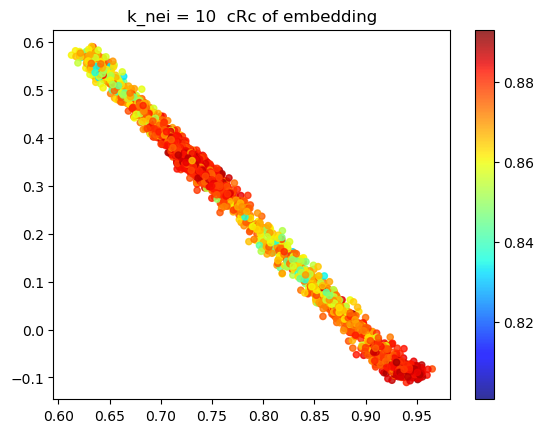

In [65]:
plt.scatter(X_mu[:,0],X_mu[:,1], c=cRc_arr, s=20, alpha=0.8,cmap=plt.cm.jet)
plt.colorbar()
plt.title('k_nei = {k_nei}  cRc of embedding'.format(k_nei = k_nei))
plt.savefig('result/k_nei = {k_nei}embedding cRc.png'.format(k_nei = k_nei),dpi = 300)
plt.show()

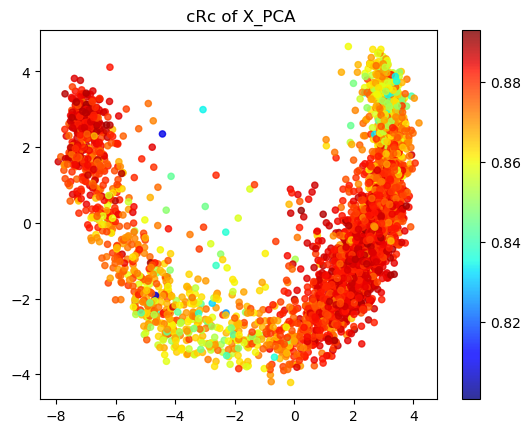

In [66]:
plt.scatter(adata0.obsm['X_pca'][:,0],adata0.obsm['X_pca'][:,1], c=cRc_arr, s=20, alpha=0.8,cmap=plt.cm.jet)
plt.colorbar()
plt.title(' cRc of X_PCA')
plt.savefig('result/cRc.png',dpi = 300)
plt.show()

In [171]:
Fisher_g=np.zeros((X.shape[0],L*2,L*2))
for i in range(X.shape[0]):
    for j in range(L):
        Fisher_g[i,2*j,2*j]=1/(X_sigma[i,0]**2)
        Fisher_g[i,2*j+1,2*j+1]=2/(X_sigma[i,0]**2)